# TASK VII: Equivariant Quantum Neural Network

In [181]:
%%capture
pip install pennylane

In [40]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from matplotlib import colors

## 0.-Generate Data

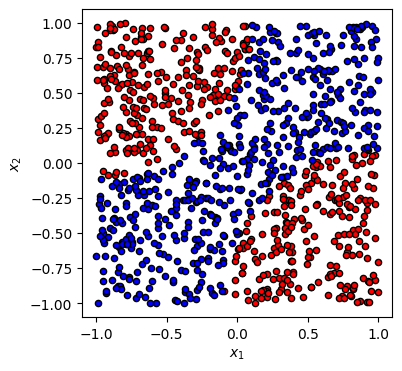

In [55]:
def Data_generate(samples, center=[[-1.0, 1.0],[1.0, -1.0]], radius=1.1):
    """
    Generates a dataset of points with 1/0 labels.

    Args:
        samples (int): number of samples to generate
        center (list): coordinates of the centers of the classes
        radius (float): radius of the classification boundary

    Returns:
        Xvals (array): coordinates of points
        yvals (array): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center[0]) < radius or np.linalg.norm(x - center[1]) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)

def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 1
    blues = y == 0
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")



Xdata, ydata = Data_generate(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

## 1.-Simple QNN classifier with data reloading and fidelity loss


In [56]:

dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


### Utility functions

In [182]:

# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)


def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)



def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)



def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Training QNN

In [62]:
num_training = 200
num_test = 2000

label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)


Xdata, y_train = Data_generate(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = Data_generate(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)


# save predictions with random weights for comparison
initial_predictions = predicted_test


loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)


best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.320453 | Train accuracy: 0.675000 | Test Accuracy: 0.605000
Epoch:  1 | Loss: 0.211509 | Train accuracy: 0.650000 | Test accuracy: 0.626500
Epoch:  2 | Loss: 0.172573 | Train accuracy: 0.720000 | Test accuracy: 0.701000
Epoch:  3 | Loss: 0.117490 | Train accuracy: 0.820000 | Test accuracy: 0.759000
Epoch:  4 | Loss: 0.090224 | Train accuracy: 0.880000 | Test accuracy: 0.830000
Epoch:  5 | Loss: 0.094134 | Train accuracy: 0.860000 | Test accuracy: 0.809500
Epoch:  6 | Loss: 0.090402 | Train accuracy: 0.885000 | Test accuracy: 0.839000
Epoch:  7 | Loss: 0.089519 | Train accuracy: 0.875000 | Test accuracy: 0.824000
Epoch:  8 | Loss: 0.090900 | Train accuracy: 0.860000 | Test accuracy: 0.810500
Epoch:  9 | Loss: 0.089672 | Train accuracy: 0.870000 | Test accuracy: 0.820000
Epoch: 10 | Loss: 0.091193 | Train accuracy: 0.850000 | Test accuracy: 0.821000


### Visualization

Cost: 0.091193 | Train accuracy 0.850000 | Test Accuracy : 0.821000
Learned weights
Layer 0: [-1.41501859  0.53763953  1.49889762]
Layer 1: [ 2.53589104 -0.05142915 -2.18779021]
Layer 2: [-1.77159235 -1.30609985  0.4367594 ]


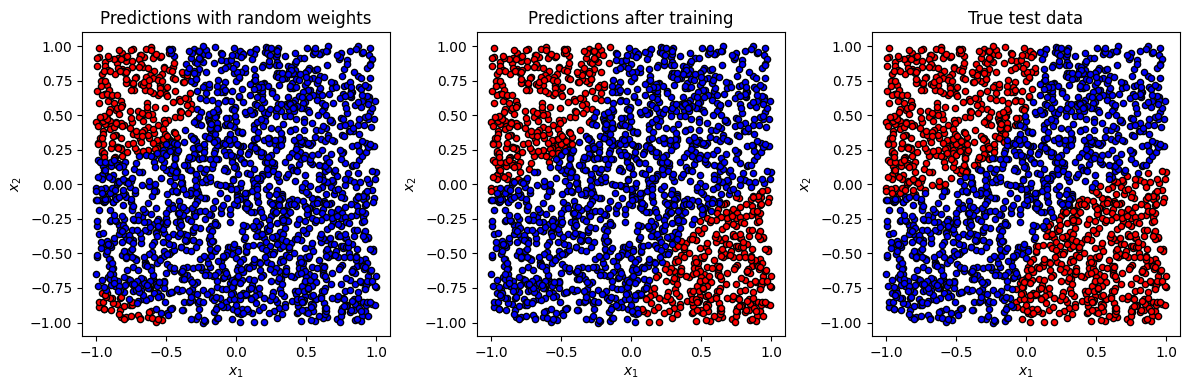

In [81]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

The implemented quantum circuit utilizes a single-wire quantum device. The qcircuit function takes three arguments: params, x, and y. The params are a matrix of parameters used within the rotational gates in the circuit. x represents an individual input vector, and y represents a label.

Within the circuit, several rotational operations are performed. In each iteration of the for loop, a Rotational gate is applied first with the angles encoded in x, and then with the rotation parameters in params. This sequence of Rotational gates is repeated for each set of parameters in params.

At the end of the circuit, the expectation value is calculated using a Hermitian observable applied to the quantum wire. This provides a quantitative measure of the similarity between the output state of the circuit and the target state density matrix associated with y.

(<Figure size 900x200 with 1 Axes>, <Axes: >)

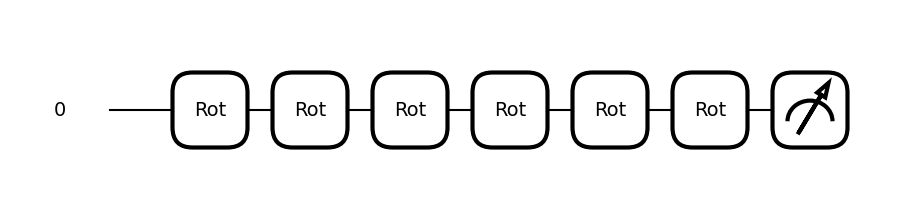

In [78]:
qml.draw_mpl(qcircuit)(params, X_train[0], density_matrix(state_labels[0]))

In [91]:
print(qml.draw(qcircuit)(params, X_train[0], density_matrix(state_labels[0])))

0: ──Rot(0.14,-0.03,0.00)──Rot(-1.42,0.54,1.50)──Rot(0.14,-0.03,0.00)──Rot(2.54,-0.05,-2.19)

───Rot(0.14,-0.03,0.00)──Rot(-1.77,-1.31,0.44)─┤  <𝓗(M0)>

M0 = 
[[1 0]
 [0 0]]


## 2.-Equivariant QNN

In [183]:
dev = qml.device("default.qubit", wires=2)

#the observables now have to be invariant under SWAP and X gates

label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)/2


@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    # prepare initial state in a invariant state
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    for p in params:
        #embedding
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)

        #Since exp(X_1+X_2) = RX_1 \cross RX_2
        qml.RX(p[0], wires=0)
        qml.RX(p[0], wires=1)

        #Rzz gates
        qml.CNOT([0,1])
        qml.RZ(p[1], wires=1)
        qml.CNOT([0,1])

    return qml.expval(qml.Hermitian(y, wires=[0,1]))


In [184]:
num_training = 200
num_test = 1000

Xdata, y_train = Data_generate(num_training)
X_train = Xdata
y_train = y_train

Xtest, y_test = Data_generate(num_test)
X_test = Xtest

# # Train using Adam optimizer and evaluate the classifier
num_layers = 5
learning_rate = 0.01
epochs = 5
batch_size = 32


# # initialize random weights
params = np.random.uniform(size=(num_layers, 2), requires_grad=True)
initial_predictions, initial_fidel = test( params, X_test, y_test, state_labels)

#best_params = np.load('best_params_eqnn.npy')
#best_params1 = np.load("/content/best_params_eqnn.npy")
#params = best_params1

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

In [185]:
loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)
best_val_accuracy = accuracy_test
best_params = params.copy()

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.571444 | Train accuracy: 0.535000 | Test Accuracy: 0.548000
Epoch:  1 | Loss: 0.523620 | Train accuracy: 0.590000 | Test accuracy: 0.620000
Epoch:  2 | Loss: 0.468959 | Train accuracy: 0.640000 | Test accuracy: 0.666000
Epoch:  3 | Loss: 0.415776 | Train accuracy: 0.735000 | Test accuracy: 0.715000
Epoch:  4 | Loss: 0.373012 | Train accuracy: 0.790000 | Test accuracy: 0.764000
Epoch:  5 | Loss: 0.345991 | Train accuracy: 0.800000 | Test accuracy: 0.788000


In [188]:
#np.save("best_params_1.npy", best_params)

Cost: 0.247067 | Train accuracy 0.690000 | Test Accuracy : 0.638000
Learned weights
Layer 0: [-0.88446575 -0.28292902]
Layer 1: [1.02745229 0.38282994]
Layer 2: [2.63963638 3.57993467]
Layer 3: [-0.247908    1.72952768]
Layer 4: [-0.97763267  1.21405568]


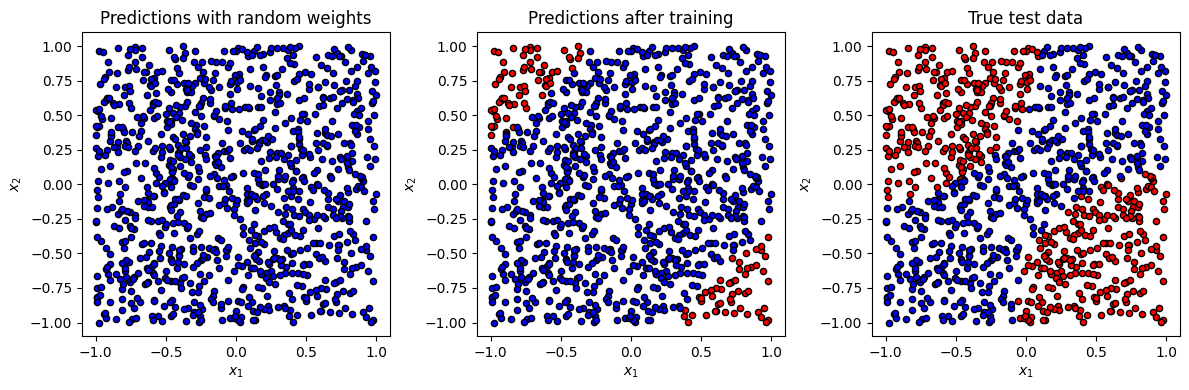

In [135]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

(<Figure size 2900x300 with 1 Axes>, <Axes: >)

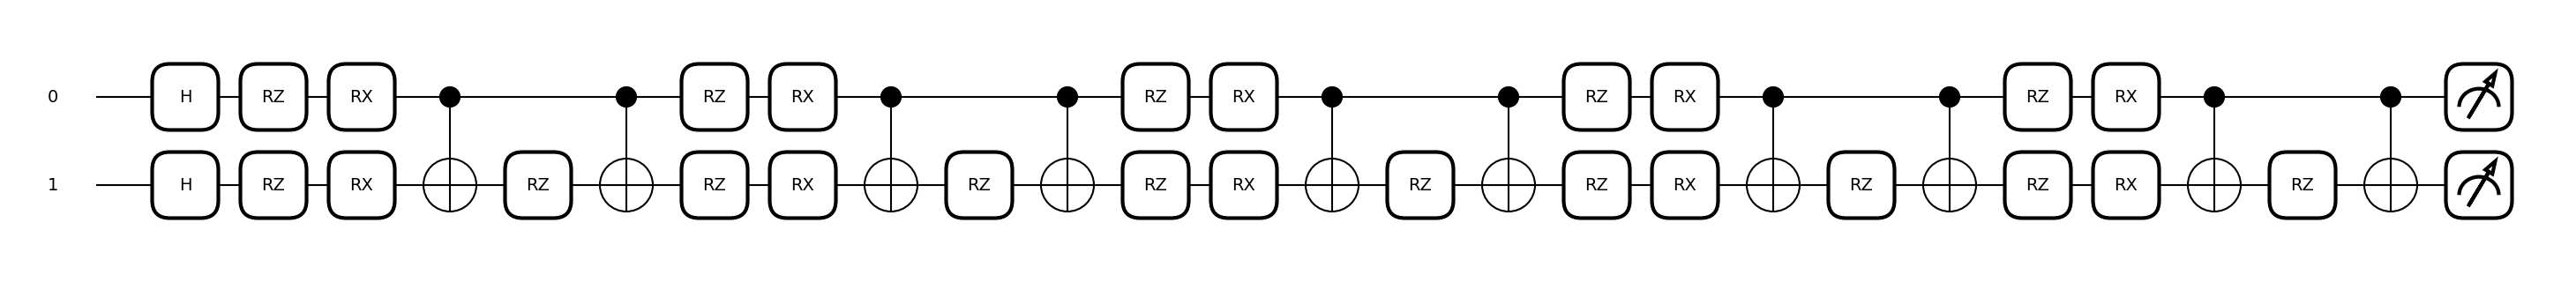

In [112]:
qml.draw_mpl(qcircuit)(params, X_train[0], density_matrix(state_labels[0]))

In [116]:
print(qml.draw(qcircuit)(params, X_train[0], density_matrix(state_labels[0])))

0: ──H──RZ(0.83)───RX(-0.89)─╭●────────────╭●──RZ(0.83)───RX(1.04)─╭●───────────╭●──RZ(0.83)─
1: ──H──RZ(-0.76)──RX(-0.89)─╰X──RZ(-0.25)─╰X──RZ(-0.76)──RX(1.04)─╰X──RZ(0.35)─╰X──RZ(-0.76)

───RX(2.60)─╭●───────────╭●──RZ(0.83)───RX(-0.27)─╭●───────────╭●──RZ(0.83)───RX(-1.00)─╭●──────────
───RX(2.60)─╰X──RZ(3.58)─╰X──RZ(-0.76)──RX(-0.27)─╰X──RZ(1.70)─╰X──RZ(-0.76)──RX(-1.00)─╰X──RZ(1.24)

──╭●─┤ ╭<𝓗(M0)>
──╰X─┤ ╰<𝓗(M0)>

M0 = 
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


### To demonstrate preservation of input symmetry

We are testing the circuit to demonstrate that the equivariant model accounts for the input order.


This means that the output differs even if the input is the same, considering the order of values.
For instance:
- T1: Original point (x1, x2)
- T2: Transformed from (x1, x2) to (-x1, -x2)
- T3: Position change from (x1, x2) to (x2, x1)

In [117]:
D = density_matrix(state_labels[0])

#we evaluate the quantum circuit in each input with differences in the order
T1 = qcircuit(params,X_test[0] ,D)
T2 = qcircuit(params,-X_test[0] ,D)
T3 = qcircuit(params,X_test[0, [1,0]] ,D)

print(T1 == T2, T1 == T3)

False False


Let's look the output of each input

In [128]:
T1

tensor(0.33089112, requires_grad=True)

In [119]:
T2

tensor(0.33089112, requires_grad=True)

In [129]:
T3

tensor(0.33089112, requires_grad=True)

All the outputs have the same value but they are different, with this result, we check that the model considers the input order.

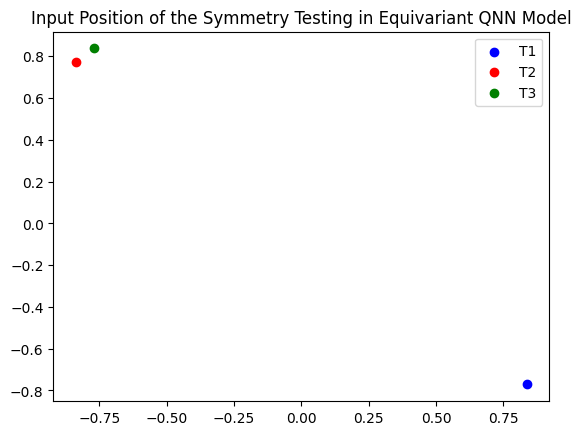

In [131]:
plt.scatter(X_test[0][0], X_test[0][1], color = "b", label = "T1")  #this is the original point (x1,x2)
plt.scatter(-X_test[0][0], -X_test[0][1], color = "r", label = "T2") #this is from (x1,x2) ----> (-x1, -x2)
plt.scatter(X_test[0][1], X_test[0][0], color = "g", label = "T3")  #this change the position (x1, x2) ---> (x2,x1)
plt.title("Input Position of the Symmetry Testing in Equivariant QNN Model")
plt.legend()
plt.show()

### References:


[1] [Quynh T. Nguyen et al. "Theory for Equivariant Quantum Neural Networks." arXiv:2210.08566, Oct, 2022.](https://arxiv.org/abs/2210.08566)

[2] [Johannes Jakob Meyer et al. "Exploiting symmetry in variational quantum machine learning." arXiv:2205.06217, May, 2022.](https://arxiv.org/abs/2205.06217)



[3] [Zhongtian Dong, Marçal Comajoan Cara,, Gopal Ramesh Dahale, Roy T. Forestano,
Sergei Gleyzer, Daniel Justice, Kyoungchul Kong, Tom Magorsch, Konstantin T. Matchev, Katia Matcheva and Eyup B. Unlu. "Z2 × Z2 Equivariant Quantum Neural Networks: Benchmarking against Classical Neural Networks." Mar, 2024.](https://arxiv.org/pdf/2311.18744.pdf)


[4] [Ahmed, Shahnawaz. "Data-reuploading classifier." PennyLane Demos, Oct, 2019.](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier/#talk-is-cheap-show-me-the-code-linus-torvalds)


[5] [Pérez-Salinas, Adrián, et al. “Data re-uploading for a universal quantum classifier.” arXiv preprint arXiv:1907.02085 (2019).](https://arxiv.org/abs/1907.02085)

